# Code for competition

In [1]:
import tensorflow as tf
import numpy as np
import os
import shutil
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare the environment

In [2]:
train_split = 0.8

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path 
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)
    
        class_source = source + '/' + folder                                                   # Create path of the class
        files = os.listdir(class_source)                                                       # List of files for the class
        random.shuffle(files)
        
        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            dest = shutil.copy(class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])  # Copy an image in the training set
        
        # Create validation set randomly
        for j in range(i + 1, len(files)):
            dest = shutil.copy(class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])  # copy an image in the validation set

### Models metadata

In [3]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
batch_size = 128
epochs = 400
classes = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Prepare the validation set for evaluation purposes

In [13]:
samples = []
targets = []

dest_valid = os.getcwd() + '/validation'

i=0
for folder in os.listdir(dest_valid):
    dest_class = dest_valid + '/' + folder
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0)) / 255
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
    i += 1

X_val = np.array(samples)
y_val = np.array(targets, dtype=np.uint8)
print(X_val.shape, X_val.dtype, sep=", ")
print(y_val.shape, y_val.dtype, sep=", ")

# Compute the class weights in order to balance loss during training
y_numeric = []
for v in y_val:
    y_numeric.append(np.argmax(v))

labels = np.unique(np.fromiter([np.argmax(t) for t in y_val], np.int32))
    
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))
print(class_weights)

(713, 96, 96, 3), float64
(713, 8), uint8
{0: 2.3453947368421053, 1: 0.8329439252336449, 2: 0.8652912621359223, 3: 0.8652912621359223, 4: 0.8329439252336449, 5: 1.9805555555555556, 6: 0.8252314814814815, 7: 0.8737745098039216}


### Online augmentation
Lets create the generators we'll need...

In [7]:
train_data_gen = ImageDataGenerator(rotation_range=180,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=(1, 1.1),
                                    #channel_shift_range=150,
                                    #shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    #vertical_flip=True,
                                    fill_mode='constant',
                                    rescale=1./255)

valid_data_gen = ImageDataGenerator(rescale=1./255)

... using flow_from_directory

In [8]:
# Paths
path = os.getcwd()
training_dir = path + '/training'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',    # Targets are directly converted into one-hot vectors
                                               shuffle=True,
                                               seed=seed)  

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size, 
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.uint8),  # TODO: maybe we can set the target to be uint8
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

valid_dataset = valid_dataset.repeat()

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


### Models definition functions

In [9]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.InceptionV3(include_top=False,
                                            weights="imagenet",
                                            input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### Define the model

In [10]:
model = build_tl_model(input_shape)

# Use the supernet only as feature extractor (eventually apply fine tuning)
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers[:-1]):
  #print(layer)
  layer.trainable=False

model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 gap_dropout (Dropout)       (None, 2048)              0         
                                                                 
 classifier (Dense)          (None, 512)               1049088   
                                                                 
 output_layer (Dense)        (None, 8)                 4104      
                                                          

### Train the model

In [11]:
# Transfer learning preprocessing (to be included in the preprocessing)
#from tensorflow.keras.applications.vgg16 import preprocess_input
#X_train_tl = np.array(preprocess_input(X_train), dtype=np.uint8)
#X_val_tl = np.array(preprocess_input(X_val), dtype=np.uint8)

history = model.fit(x=train_dataset,
                    epochs=epochs,                   # Only indicative since we set "repeat" in training and validation datasets
                    steps_per_epoch=len(train_gen),
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/400
 1/23 [>.............................] - ETA: 5:30 - loss: 2.1972 - accuracy: 0.0547

KeyboardInterrupt: 

### Plot training results

In [12]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

NameError: name 'history' is not defined

<Figure size 1500x500 with 0 Axes>

### Plot the confusion matrix (evaluated on the validation set)

(713, 96, 96, 3), float64
(713, 8), uint8
23/23 [==============================] - 2s 72ms/step
Accuracy: 0.7868
Precision: 0.7747
Recall: 0.741
F1: [0.3714 0.8448 0.7746 0.8033 0.8    0.7595 0.9315 0.6782]


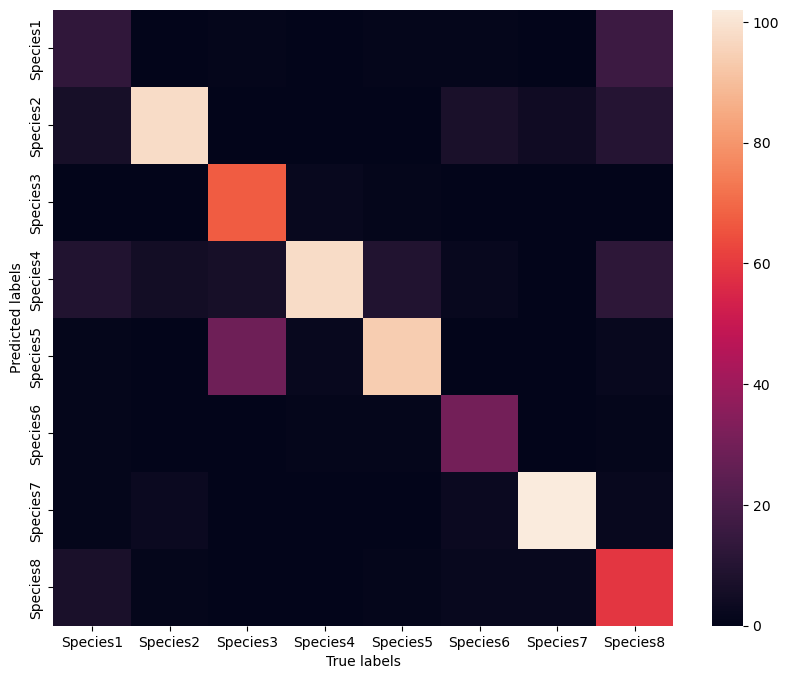

In [ ]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [ ]:
restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(X_val, y_val, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

ResourceExhaustedError: Graph execution error:

Detected at node 'conv_dense_model_v1/conv1/Relu' defined at (most recent call last):
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tomma\AppData\Local\Temp\ipykernel_11472\1423806063.py", line 2, in <cell line: 2>
      restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)  #TODO: not right because validation set can change
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'conv_dense_model_v1/conv1/Relu'
OOM when allocating tensor with shape[32,256,96,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv_dense_model_v1/conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_45813]